In [1]:
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation
import numpy as np 
%matplotlib inline

In [2]:
dataset_dir = "/home/jay/Developer/Robotics/Harvard/CS283/FinalProject/feature_vo/datasets/traj1_frei_png/"
# dataset_dir = "/home/jay/Developer/Robotics/Harvard/CS283/FinalProject/feature_vo/datasets/test/"
a_idx = 1
b_idx = 100
im_a_path = dataset_dir + "rgb/{}.png".format(a_idx)
im_b_path = dataset_dir + "rgb/{}.png".format(b_idx)

traj_path = dataset_dir + "groundtruth.txt"

def read_img(path):
    im = cv2.imread(path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im

In [3]:
class Pose:
    def __init__(self):
        self.T = np.identity(4)
    
    def from_t_q(self, t, q):
        """Initialize pose from translation and quaternion
        """
        t = np.asarray(t)
        rotation = Rotation.from_quat(q)
        self.T = np.identity(4)
        self.T[:3, 3] = t
        self.T[:3, :3] = rotation.as_dcm()
        
    def from_t_R(self, t, R):
        self.T = np.identity(4)
        self.T[:3, 3] = t
        self.T[:3, :3] = R
    
    def from_T(self, T):
        self.T = T

    def __str__(self):
        return str(self.T)
    
    def inverse(self):
        T_inv = np.linalg.inv(self.T)
        pose = Pose()
        pose.from_T(T_inv)
        return pose

    def __mul__(self, other):
        T = np.matmul(self.T, other.T)
        pose = Pose()
        pose.from_T(T)
        return pose
    
    def t(self):
        return self.T[:3, 3]
    
    def R(self):
        return self.T[:3, :3]

def get_relative_pose(i, j):
    """Get relative pose from i to j
    """
    assert(i < j)
    pose_i = None
    pose_j = None
    with open(traj_path, 'r') as f:
        line = f.readline()
        while line:
            values = [float(x) for x in line.split()]
            assert(len(values) == 8)
            if values[0] == i:
                pose_i = Pose()
                pose_i.from_t_q(values[1:4], values[4:])
            if values[0] == j:
                pose_j = Pose()
                pose_j.from_t_q(values[1:4], values[4:])
                break
            line = f.readline()
    assert(pose_i is not None and pose_j is not None)
    relative_pose = pose_i.inverse() * pose_j
    return relative_pose

def get_pose(i):
    with open(traj_path, 'r') as f:
        line = f.readline()
        while line:
            values = [float(x) for x in line.split()]
            assert(len(values) == 8)
            if values[0] == i:
                pose = Pose()
                pose.from_t_q(values[1:4], values[4:])
                return pose
            line = f.readline()

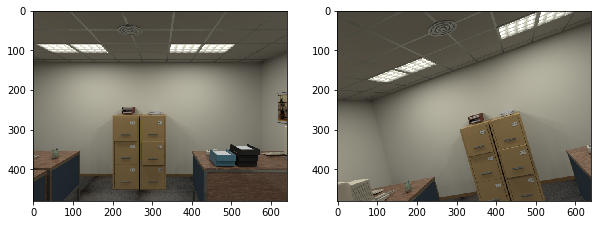

In [4]:
# Load images
im_a = read_img(im_a_path)
im_b = read_img(im_b_path)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(im_a)

plt.subplot(1, 2, 2)
plt.imshow(im_b)

In [5]:
relative_pose = get_relative_pose(a_idx, b_idx)
print(relative_pose)

[[ 0.92323536  0.27639131 -0.26691631  0.137385  ]
 [-0.27062282  0.96087988  0.05893343 -0.0121241 ]
 [ 0.2727632   0.01782422  0.96191608  0.49208   ]
 [ 0.          0.          0.          1.        ]]


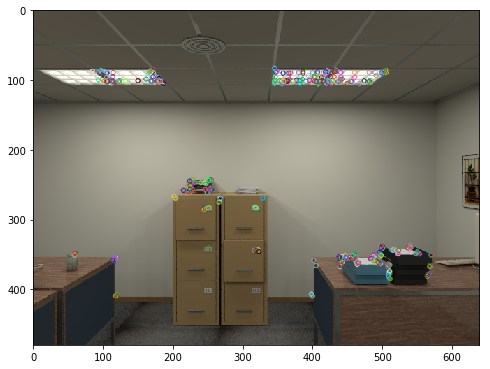

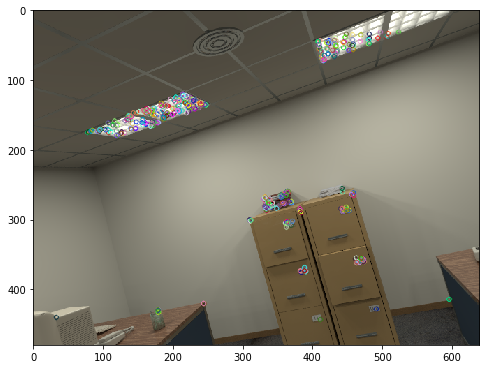

In [6]:
# Feature detection
# detector = cv2.xfeatures2d.SIFT_create()
detector = cv2.ORB_create()

def find_kp(detector, im, show=False):
    kp = detector.detect(im, None)
    if show:
        im_kp = cv2.drawKeypoints(im, kp, None)
        plt.figure(figsize=(8, 8))
        plt.imshow(im_kp)
    return kp

kp_a = find_kp(detector, im_a, show=True)
kp_b = find_kp(detector, im_b, show=True)

In [7]:
# Compute descriptors
kp_a, des_a = detector.compute(im_a, kp_a)
kp_b, des_b = detector.compute(im_b, kp_b)

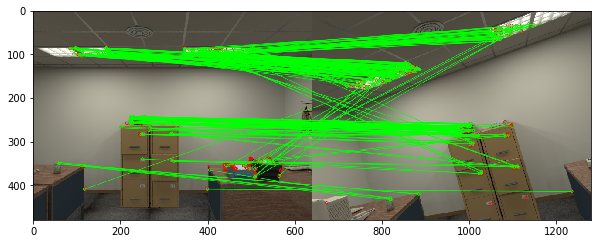

In [8]:
# Match keypoints
def match_kp(des1, des2, show=False, img1=None, kp1=None, img2=None, kp2=None):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)

    matcher = cv2.FlannBasedMatcher(index_params, search_params)
    matches = matcher.knnMatch(des1, des2, k=2)
    matches_mask = [[0,0] for i in range(len(matches))]

    good_matches = []
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            matches_mask[i]=[1,0]
            good_matches.append(m)

    draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matches_mask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)
    if show:
        img = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, **draw_params)
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
    return matches, matches_mask, good_matches


def match_kp_orb(des1, des2, show=False, img1=None, kp1=None, img2=None, kp2=None):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)

    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = matcher.match(des1, des2)

    draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   flags = cv2.DrawMatchesFlags_DEFAULT)
    if show:
        img = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, **draw_params)
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
    return matches

# matches, matches_mask, good_matches = match_kp(des_a, des_b, True, im_a, kp_a, im_b, kp_b);
good_matches = match_kp_orb(des_a, des_b, True, im_a, kp_a, im_b, kp_b);

In [9]:
def print_match_stat(match):
    print("img idx: {}".format(match.imgIdx))
    print("query idx: {}".format(match.queryIdx))
    print("train idx: {}".format(match.trainIdx))

In [10]:
# Get good keypoints
def get_matched_kp(kp1, kp2, good_matches):
    matched_kp1 = []
    matched_kp2 = []
    for match in good_matches:
        matched_kp1.append(kp1[match.queryIdx].pt)
        matched_kp2.append(kp2[match.trainIdx].pt)
    return np.asarray(matched_kp1), np.asarray(matched_kp2)

pts_a, pts_b = get_matched_kp(kp_a, kp_b, good_matches)

In [11]:
# Find relative pose
K = np.array([[481.20, 0, 319.50],
              [0, -480.00, 239.50],
              [0, 0, 1]])
# K = np.array([[525, 0, 319.50],
#               [0, 525, 239.50],
#               [0, 0, 1]])
pts_a_norm = cv2.undistortPoints(np.expand_dims(pts_a, axis=1), cameraMatrix=K, distCoeffs=None)
pts_b_norm = cv2.undistortPoints(np.expand_dims(pts_b, axis=1), cameraMatrix=K, distCoeffs=None)

E, mask = cv2.findEssentialMat(pts_a_norm, pts_b_norm, focal=1.0, pp=(0, 0), method=cv2.RANSAC, prob=0.999, threshold=0.1)
points, R, t, mask = cv2.recoverPose(E, pts_a_norm, pts_b_norm)

In [12]:
print("E:\n{}".format(E))
print("R:\n{}".format(R))
print("t: {}".format(t.T))

E:
[[ 0.18725524  0.6099012  -0.08319413]
 [-0.5580917   0.1674358  -0.38748214]
 [ 0.17585392  0.25476831  0.02365901]]
R:
[[ 0.95026494 -0.27076338  0.1538952 ]
 [ 0.26983933  0.96251925  0.02726599]
 [-0.15550972  0.01561707  0.98771091]]
t: [[ 0.41481259 -0.14392013 -0.89845285]]


In [13]:
import pose_estimation
reload(pose_estimation)
from pose_estimation.estimation import PoseEstimator
R, t = PoseEstimator.recover_pose(E, pts_a_norm, pts_b_norm, mask)
print("R:")
print(R)
print("t: {}".format(t))

(array([[ 0.95026494, -0.27076338,  0.1538952 ],
        [ 0.26983933,  0.96251925,  0.02726599],
        [-0.15550972,  0.01561707,  0.98771091]]), array([[ 0.41481259],
        [-0.14392013],
        [-0.89845285]]))

In [14]:
estimated_pose = Pose()
estimated_pose.from_t_R(t.flatten(), R)
estimated_pose = estimated_pose.inverse()
print(estimated_pose)

[[ 0.95026494  0.26983933 -0.15550972 -0.4950647 ]
 [-0.27076338  0.96251925  0.01561707  0.26487315]
 [ 0.1538952   0.02726599  0.98771091  0.82749813]
 [ 0.          0.          0.          1.        ]]


In [15]:
print(relative_pose)

[[ 0.92323536  0.27639131 -0.26691631  0.137385  ]
 [-0.27062282  0.96087988  0.05893343 -0.0121241 ]
 [ 0.2727632   0.01782422  0.96191608  0.49208   ]
 [ 0.          0.          0.          1.        ]]


In [16]:
# Fix translation scale
mag_true = np.linalg.norm(relative_pose.t())
estimated_pose.T[:3, 3] = mag_true * estimated_pose.t()
print(estimated_pose)

[[ 0.95026494  0.26983933 -0.15550972 -0.25299906]
 [-0.27076338  0.96251925  0.01561707  0.13536141]
 [ 0.1538952   0.02726599  0.98771091  0.42288665]
 [ 0.          0.          0.          1.        ]]


<IPython.core.display.Javascript object>


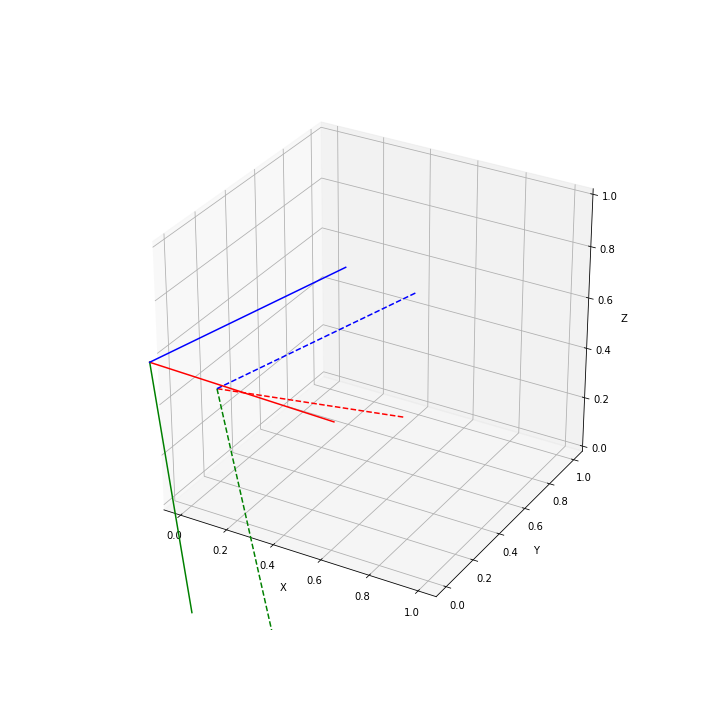

In [18]:
%matplotlib notebook
# Plot pose
def plot_pose(ax, pose, length=1, style="-"):
    colors = ['r', 'g', 'b']
    lines = sum([ax.plot([], [], [], c=c) for c in colors], [])
    pos = pose.t()
    start_points = np.array([pos, pos, pos])
    end_points = np.array([[length, 0, 0], [0, 0, -length], [0, length, 0]]).T
    end_points = np.matmul(pose.R(), end_points).T + start_points
    
    for line, start, end in zip(lines, start_points, end_points):
        line.set_data((start[0], end[0]), (start[1], end[1]))
        line.set_3d_properties((start[2], end[2]))
        line.set_linestyle(style)
        ax.draw_artist(line)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
fig.canvas.draw()
plot_pose(ax, relative_pose, style="--")
plot_pose(ax, estimated_pose, style="-")